##번역가는 대화에도 능하다

개발 환경
<br/>데이터 정보
<br/>데이터 탐색
<br/>데이터 전처리


Data Augmentation
<br/>Word2Vec
<br/>Glove
<br/>FastText
<br/>Lexical Substitution
<br/>File I/O

Data Vectorization

모델 구성
<br/>Transformer
<br/>Learning Rate Schedule
<br/>Loss Function
<br/>Train Step
<br/>Evaluation

BLEU Score
<br/>Hyperparameter
<br/>First Model
<br/>Second Model
<br/>최종 모델
<br/>결론
<br/>참고문헌

#개발 환경

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

한글 폰트를 설치한다.
<br/>혹시 깨짐현상이 발생하는 경우 런타임을 다시 시작하고 matplotlib 모듈을 실행하면 한글이 출력된다.

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

In [ ]:
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

Google Colab에 한글 폰트가 설치되어 있는지 확인한다.

In [ ]:
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

PCA Scatter Plot을 확인하기 위해 한국어를 지원하는 폰트로 변경한다.

In [ ]:
!pip install fasttext

In [ ]:
import os
# install konlpy, jdk, JPype
!pip install konlpy
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip3 install JPype1-py3

# install mecab-ko
os.chdir('/tmp/')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
!tar zxfv mecab-0.996-ko-0.9.2.tar.gz
os.chdir('/tmp/mecab-0.996-ko-0.9.2')
!./configure
!make
!make check
!make install

# install mecab-ko-dic
!apt-get install automake
os.chdir('/tmp')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
!tar -zxvf mecab-ko-dic-2.1.1-20180720.tar.gz
os.chdir('/tmp/mecab-ko-dic-2.1.1-20180720')
!./autogen.sh
!./configure
!make
!make install

# install mecab-python
os.chdir('/content')
!git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
os.chdir('/content/mecab-python-0.996')
!python3 setup.py build
!python3 setup.py install

In [ ]:
import os
import csv
import pickle
import math
import random
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing import sequence
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [ ]:
from tqdm.notebook import tqdm
from IPython.display import HTML
from IPython.display import Image

In [ ]:
import re
from konlpy.tag import Mecab

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
import fasttext
import fasttext.util

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['numpy=', 'pandas=', 'tensorflow=', 'keras=', 'scikit-learn=', 'tqdm=', 'matplotlib=',
                'regex=', 'gensim=', 'nltk=', 'konlpy=', 'fasttext=', 'pickle=', 'nltk=']
library_version = []
f = open('/content/drive/MyDrive/lms/library_version.txt', 'r')
line = f.readline()
while True:
    line = f.readline()
    if not line:
      break
    for i in library_name:
      if i in line:
        library_version.append(line)
        library_version.append('    ')

f.close()

import sys
print(sys.version)
print()

for i in range(0, len(library_version) - 1, 6):
  print(str(library_version[i : i+6]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='') 
  if i % 6 == 0:
    print()

for i in range(len(library_version) - 1):
  if (i-1) % 6 == 0 and i == len(library_version) - 6:
    print(str(library_version[-1]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다

#데이터 정보

[Chatbot data for Korean v1.0](https://github.com/songys/Chatbot_data)

다음 카페 [사랑보다 아름다운 실연](http://cafe116.daum.net/_c21_/home?grpid=1bld)에서 자주 나오는 이야기들을 참고하여 제작한 데이터셋이다.
<br/>챗봇 트레이닝용 문답 페어가 11,876개이다.
<br/>일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링했다.
<br/>읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장한다.

In [ ]:
chatbot_data = pd.read_table('/content/drive/MyDrive/lms/transformer_chatbot/ChatbotData.csv')
chatbot_data.head()

,"Q,A,label"
0,"12시 땡!,하루가 또 가네요.,0"
1,"1지망 학교 떨어졌어,위로해 드립니다.,0"
2,"3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0"
3,"3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0"
4,"PPL 심하네,눈살이 찌푸려지죠.,0"


In [ ]:
chatbot_qna = chatbot_data["Q,A,label"].str.split(',')
chatbot_qna = chatbot_qna.apply(lambda x: pd.Series(x))
chatbot_qna = chatbot_qna.loc[:, [0, 1]]
chatbot_qna.columns = ['question', 'answer']

In [ ]:
chatbot_qna

,question,answer
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


In [ ]:
question = []
for i in range(len(chatbot_qna['question'])):
  question.append(chatbot_qna['question'][i])

print("Data Size :", len(question))
print()
print("Example")
for question_sen in question[:100][::20]: print("", question_sen)

Data Size : 11823

Example
 12시 땡!
 가스비 비싼데 감기 걸리겠어
 간만에 떨리니까 좋더라
 감정컨트롤을 못하겠어
 개강룩 입어볼까


In [ ]:
answer = []
for i in range(len(chatbot_qna['answer'])):
  answer.append(chatbot_qna['answer'][i])

print("Data Size :", len(answer))
print()
print("Example")
for answer_sen in answer[:100][::20]: print("", answer_sen)

Data Size : 11823

Example
 하루가 또 가네요.
 따뜻하게 사세요!
 떨리는 감정은 그 자체로 소중해요.
 그건 습관이에요.
 개시해보세요.


#데이터 탐색

Question Min Length : 1
Question Max Length : 56
Question Mean Length : 12.847162310750232
Answer Min Length : 0
Answer Max Length : 69
Answer Mean Length : 14.927091262792862



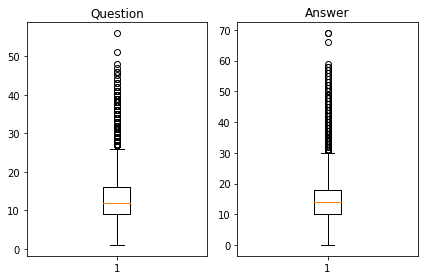

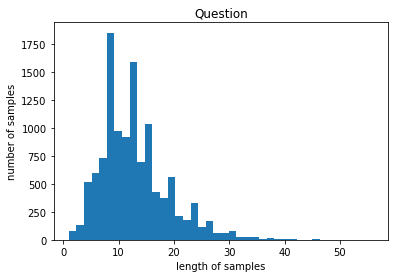

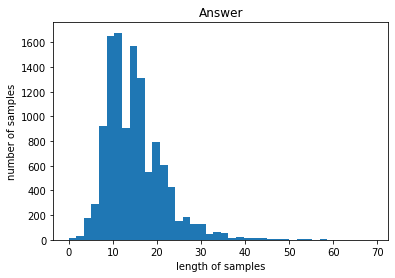

In [ ]:
num_question = np.array([len(i) for i in question])
num_answer = np.array([len(i) for i in answer])

print('Question Min Length : {}'.format(np.min(num_question)))
print('Question Max Length : {}'.format(np.max(num_question)))
print('Question Mean Length : {}'.format(np.mean(num_question)))
print('Answer Min Length : {}'.format(np.min(num_answer)))
print('Answer Max Length : {}'.format(np.max(num_answer)))
print('Answer Mean Length : {}'.format(np.mean(num_answer)))
print()
plt.subplot(1,2,1)
plt.boxplot(num_question)
plt.title('Question')
plt.subplot(1,2,2)
plt.boxplot(num_answer)
plt.title('Answer')
plt.tight_layout()
plt.show()
print()
plt.title('Question')
plt.hist(num_question, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
print()
plt.title('Answer')
plt.hist(num_answer, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
text_max_len = 40
num_max_question = np.array([len(i) for i in question if len(i) < text_max_len])
num_max_answer = np.array([len(i) for i in question if len(i) < text_max_len])

print('Text Max Length : ', text_max_len)
print('{:.2f}% of all sentences are within the text_max_len setting.'.format(100 * len(num_max_answer + num_max_question)/ len(num_answer + num_question)))

Text Max Length :  40
99.81% of all sentences are within the text_max_len setting.


적절한 최대 문장 길이를 40으로 지정한다.

#데이터 전처리

In [ ]:
def preprocess_sentence(sentence_list):

    text_max_len = 40
    corpus = []
    for sentence in sentence_list:
        sentence = sentence.lower().strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^0-9ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.strip()
        if len(sentence) <= text_max_len:
          corpus.append(sentence)
        
    return corpus

영문자의 경우 소문자로 변환한다.
<br/>영문자와 한글, 숫자, 주요 특수문자를 남기고 나머지 문자를 제외한다.
<br/>문장의 길이가 40 이상인 문장은 제외한다.

In [ ]:
def remove_repeated_sentence(question, answer):

    question_dict = {string : i for i,string in enumerate(question)}
    answer_dict = {string : i for i,string in enumerate(answer)}

    question_df = pd.DataFrame(list(question_dict.items()), columns=['value', 'key'])
    answer_df = pd.DataFrame(list(answer_dict.items()), columns=['value', 'key'])
    df_INNER_JOIN = pd.merge(question_df, answer_df, left_on='key', right_on='key', how='inner')

    question_unique = list(df_INNER_JOIN['value_x'])
    answer_unique = list(df_INNER_JOIN['value_y'])
    
    return question_unique, answer_unique

딕셔너리를 생성하면서 중복되는 key 값을 제외한다.
<br/>자료구조 딕셔너리는 중복되는 key 값을 허용하지 않는다.
<br/>데이터의 병렬 쌍이 흐트러지지 않도록 데이터프레임의 INNER JOIN을 한다.
<br/>데이터프레임의 key_x, key_y를 리스트로 저장한다.
<br/>question_unique는 중복 데이터를 제외한 질문 문장의 리스트이다.
<br/>answer_unique는 중복 데이터를 제외한 대답 문장의 리스트이다.

In [ ]:
def mecab_tokenizer(sentence_list):
  
    corpus = []

    mecab = Mecab()
    for sentence in sentence_list:
      token = mecab.morphs(sentence)
      corpus.append(token)

    return corpus

MeCab을 활용하여 토큰화한다.

In [ ]:
def build_corpus(question_raw, answer_raw):
  
    question = preprocess_sentence(question_raw)
    answer = preprocess_sentence(answer_raw)

    que_unique, ans_unique = remove_repeated_sentence(question, answer)
    que_corpus = mecab_tokenizer(que_unique)
    ans_corpus = mecab_tokenizer(ans_unique)

    return que_corpus, ans_corpus, que_unique, ans_unique

In [ ]:
que_corpus, ans_corpus, que_unique, ans_unique = build_corpus(question, answer)

In [ ]:
print("Question Sentence")
print(que_unique[0], "\n")
print("Question Morpheme Token")
print(que_corpus[0], "\n\n")
print("Answer Sentence")
print(ans_unique[0], "\n")
print("Answer Morpheme Token")
print(ans_corpus[0], "\n")

Question Sentence
3박4일 정도 놀러가고 싶다 

Question Morpheme Token
['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다'] 


Answer Sentence
여행은 언제나 좋죠 . 

Answer Morpheme Token
['여행', '은', '언제나', '좋', '죠', '.'] 



In [ ]:
print("Data Size : ({}, {})".format(len(que_corpus), len(ans_corpus)))

Data Size : (7612, 7612)


#Data Augmentation

##Word2Vec

[Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)

한국어로 사전 훈련된 단어 수준의 Word2Vec Embedding 모델이다.

In [ ]:
word2vec_path = '/content/drive/MyDrive/lms/transformer_chatbot/embedding_model/word2vec.bin'
word2vec_model = Word2Vec.load(word2vec_path)

In [ ]:
word2vec_model.wv.most_similar("길")

[('구불구불', 0.4876348078250885),
 ('가늘', 0.4853244125843048),
 ('길다랗', 0.4841133952140808),
 ('둥글', 0.4518604874610901),
 ('짧', 0.4475528597831726),
 ('기다랗', 0.4351239502429962),
 ('푸르', 0.4280202388763428),
 ('산길', 0.4273521304130554),
 ('길쭉', 0.42183613777160645),
 ('길이', 0.42086976766586304)]

In [ ]:
for i in range(0, 150, 30):
  if i > 0:
    print()
  print("from : ", que_unique[i])
  print("to : ", end='')
  for j in range(len(que_corpus[i])):
    try:
      result = word2vec_model.wv.most_similar(que_corpus[i][j])[0][0]
      print(result, end=' ')
    except KeyError: 
      print(que_corpus[i][j], end=' ')
  print()

from :  3박4일 정도 놀러가고 싶다
to : 3 김 4 월과 만큼 살 ㄹ래 놀드 기에 겠 으며 

from :  결혼 했는데 .
to : 재혼 했 으며 는데 

from :  과식했다
to : 과식 했 으며 

from :  기본이 안 되어 있어
to : 표준 그러 못가 이루어지 어서 없 어서 

from :  꽃다발 준비했어
to : 강아지 추진 했 어서 


In [ ]:
def display_pca_scatterplot(model, title, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

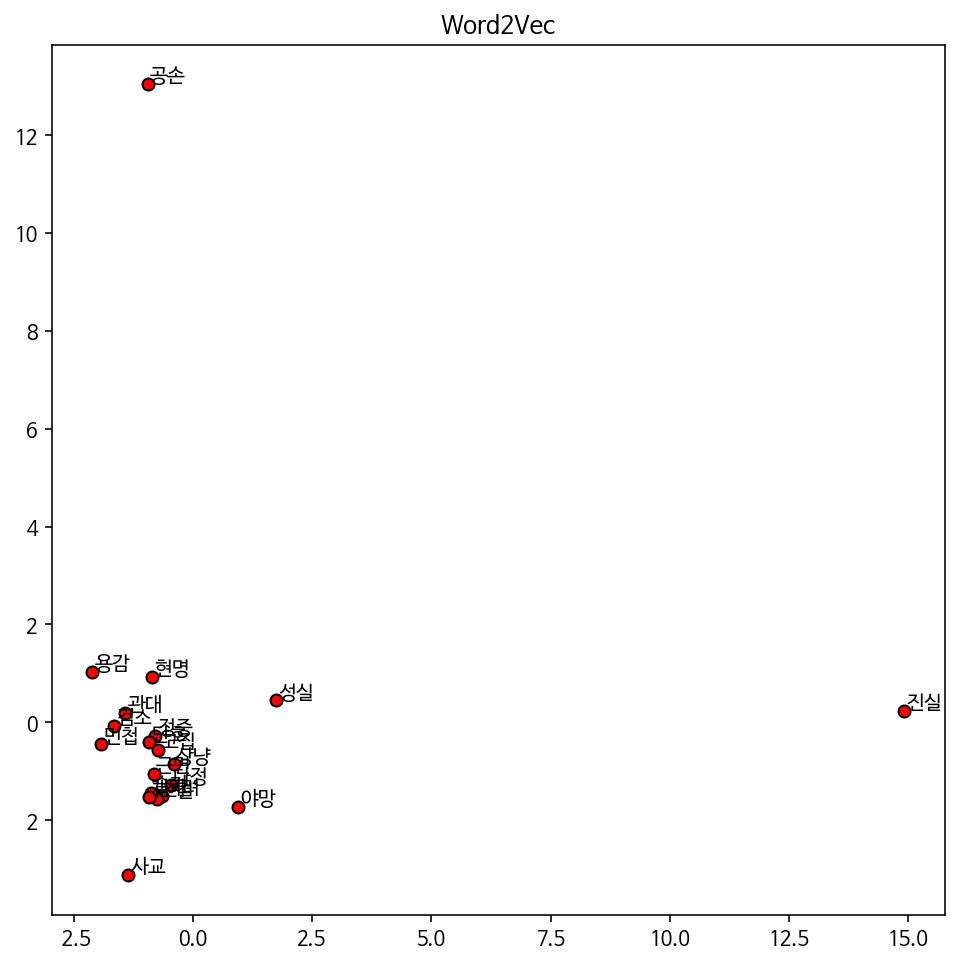

In [ ]:
display_pca_scatterplot(word2vec_model, "Word2Vec",
                        ['민첩', '야망', '용감', '공손', 
                         '정중', '근면', '성실', '단호', 
                         '관대', '상냥', '다정', '진실', 
                         '사교', '고집', '사려', '검소', 
                         '고결', '현명', '슬기', '재치'])

##Glove

[Pre-trained word embedding vector](https://ratsgo.github.io/embedding/downloaddata.html)

학습이 완료된 단어 수준 임베딩 모델이다.
<br/>FastText-Jamo를 제외한 모든 임베딩은 한국어 위키백과, KorQuAD, 네이버 영화 말뭉치를 은전한닢(mecab)으로
<br/>형태소 분석한 말뭉치로 학습됐다.

In [ ]:
glove2word2vec(glove_input_file='/content/drive/MyDrive/lms/transformer_chatbot/embedding_model/glove.txt',
               word2vec_output_file='/content/drive/MyDrive/lms/transformer_chatbot/embedding_model/gensim_glove_vectors.txt')

In [ ]:
glove_path = '/content/drive/MyDrive/lms/transformer_chatbot/embedding_model/gensim_glove_vectors.txt'
glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False)

In [ ]:
glove_model.most_similar("길")

[('삼', 0.7340559959411621),
 ('교차로', 0.7128734588623047),
 ('거리', 0.7117969989776611),
 ('고개', 0.6495471596717834),
 ('교', 0.6426589488983154),
 ('로', 0.6424239277839661),
 ('마을', 0.6404488682746887),
 ('서', 0.6330164670944214),
 ('앞', 0.6325525641441345),
 ('입구', 0.6304036378860474)]

In [ ]:
for i in range(0, 150, 30):
  if i > 0:
    print()
  print("from : ", que_unique[i])
  print("to : ", end='')
  for j in range(len(que_corpus[i])):
    try:
      result = glove_model.most_similar(que_corpus[i][j])[0][0]
      print(result, end=' ')
    except KeyError: 
      print(que_corpus[i][j], end=' ')
  print()

from :  3박4일 정도 놀러가고 싶다
to : 4 김 5 월 만큼 다니 와서 는 하 겠 었 

from :  결혼 했는데 .
to : 아내 였 또 다 

from :  과식했다
to : 과음 였 었 

from :  기본이 안 되어 있어
to : 요소 은 보 었 되 다 되 

from :  꽃다발 준비했어
to : 쉐이미 위해 였 되 


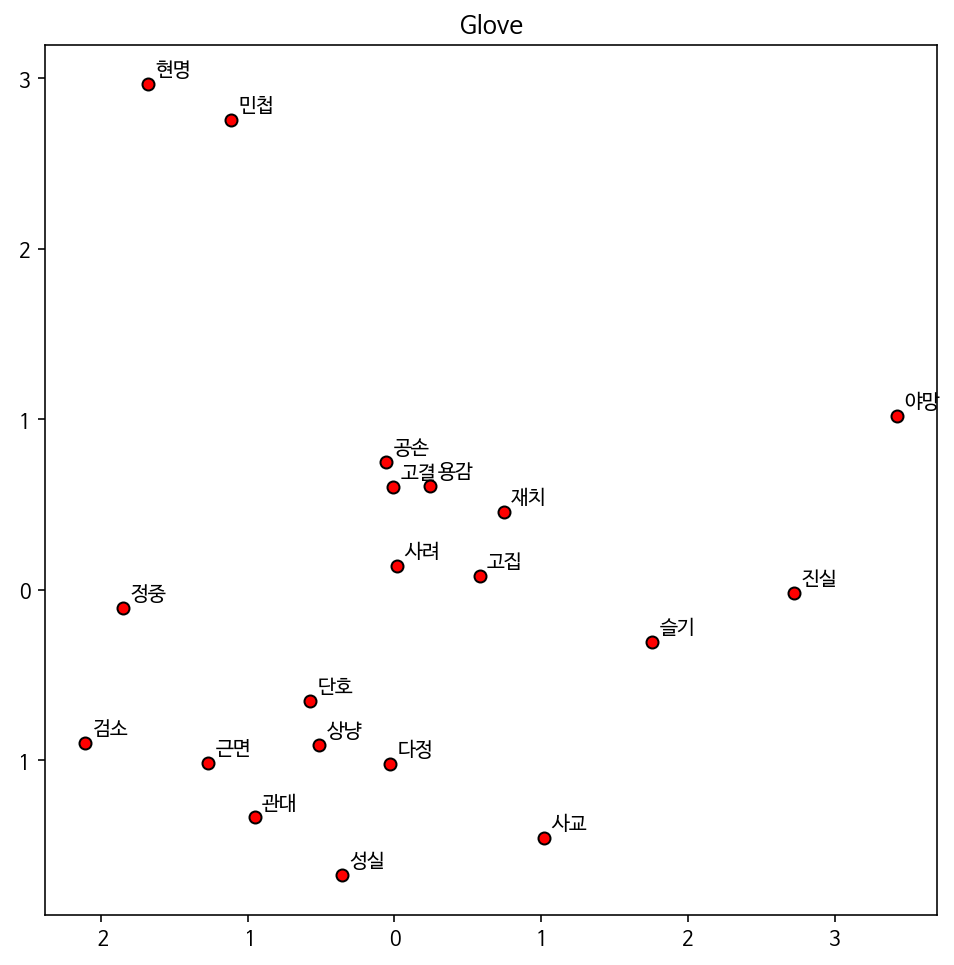

In [ ]:
display_pca_scatterplot(glove_model, "Glove",
                        ['민첩', '야망', '용감', '공손', 
                         '정중', '근면', '성실', '단호', 
                         '관대', '상냥', '다정', '진실', 
                         '사교', '고집', '사려', '검소', 
                         '고결', '현명', '슬기', '재치'])

##FastText

[Word vectors for 157 languages](https://fasttext.cc/docs/en/crawl-vectors.html)

FastText 공식 사이트의 사전학습 모델 파일 용량이 4.2GB에 달하여 작업 시간이 오래 걸린다.
<br/>따라서 용량이 가벼운 모델 파일을 대신 사용한다.

[Pre-trained word embedding vector](https://ratsgo.github.io/embedding/downloaddata.html)

학습이 완료된 단어 수준 임베딩 모델이다.
<br/>FastText-Jamo를 제외한 모든 임베딩은 한국어 위키백과, KorQuAD, 네이버 영화, 은전한닢(mecab) 코퍼스로 학습됐다.

In [ ]:
fastext_path = '/content/drive/MyDrive/lms/transformer_chatbot/embedding_model/fasttext.bin'
fastext_model = fasttext.load_model(fastext_path)

In [ ]:
fastext_model.get_nearest_neighbors('길')

[(0.6960369348526001, '안길'),
 (0.680328905582428, '다평'),
 (0.674354076385498, '허궁다리'),
 (0.6734952926635742, '한다리'),
 (0.6731016039848328, '쪽다리'),
 (0.6721546649932861, '잠로'),
 (0.6712022423744202, '거길'),
 (0.6651454567909241, '산길'),
 (0.6600451469421387, '들길'),
 (0.6581897735595703, '무네미로')]

In [ ]:
for i in range(0, 150, 30):
  if i > 0:
    print()
  print("from : ", que_unique[i])
  print("to : ", end='')
  for j in range(len(que_corpus[i])):
    try:
      result = fastext_model.get_nearest_neighbors(que_corpus[i][j])[0][1]
      print(result, end=' ')
    except KeyError: 
      print(que_corpus[i][j], end=' ')
  print()

from :  3박4일 정도 놀러가고 싶다
to : 4 김 5 월 만큼 빈둥빈둥 와서 는 하 진짜로 이 

from :  결혼 했는데 .
to : 재혼 였 또 다 

from :  과식했다
to : 신경과민 였 이 

from :  기본이 안 되어 있어
to : 공통 은 방 었 져 으며 져 

from :  꽃다발 준비했어
to : 쉐이미 만반 였 져 


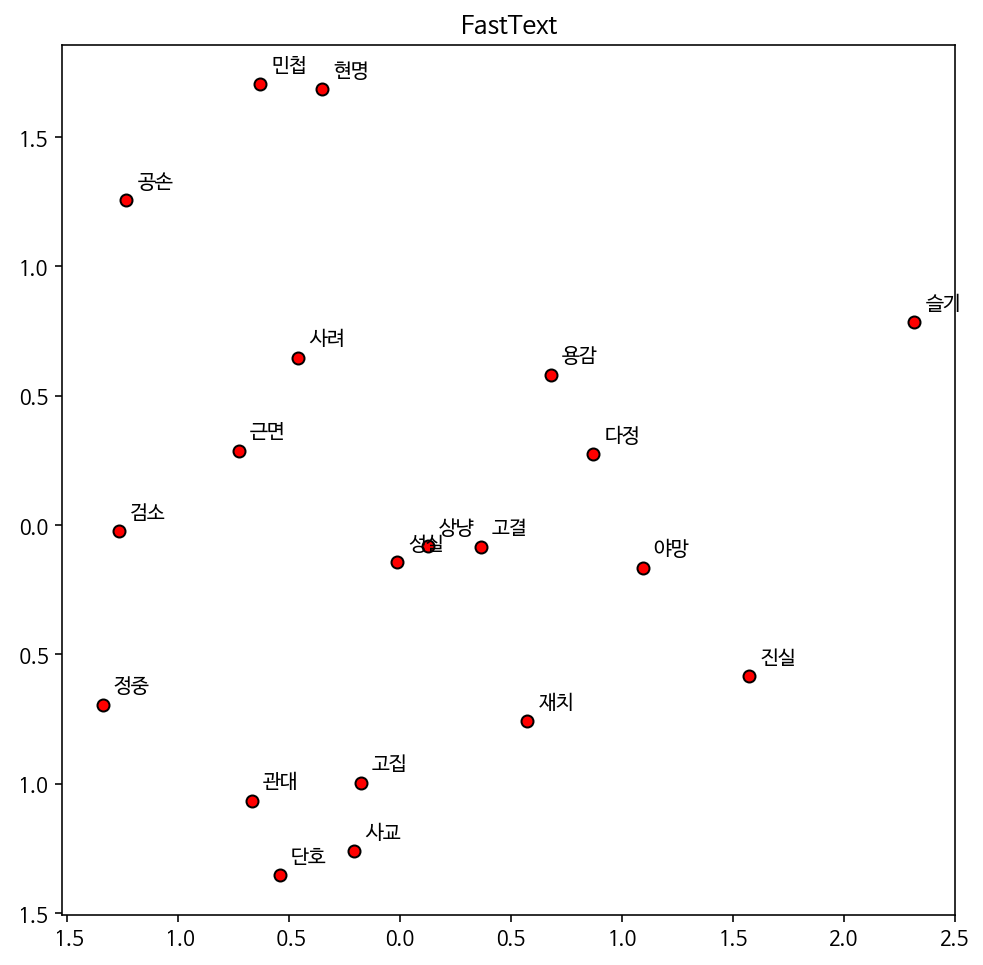

In [ ]:
display_pca_scatterplot(fastext_model, "FastText",
                        ['민첩', '야망', '용감', '공손', 
                         '정중', '근면', '성실', '단호', 
                         '관대', '상냥', '다정', '진실', 
                         '사교', '고집', '사려', '검소', 
                         '고결', '현명', '슬기', '재치'])

##Lexical Substitution

In [ ]:
def lexical_sub(sentence, word_vector):
    try:
        i = np.random.randint(len(sentence))
        result = sentence[::]
        if word_vector == word2vec_model:
          result[i] = word2vec_model.wv.most_similar(sentence[i])[0][0]

        elif word_vector == glove_model:
          result[i] = glove_model.most_similar(sentence[i])[0][0]

        elif word_vector == fastext_model:
          result[i] = fastext_model.get_nearest_neighbors(sentence[i])[0][1]

    except:   
        return None

    return result

In [ ]:
def augment_corpus(src_corpus, tgt_corpus, word_vector):
    new_src_corpus = []
    new_tgt_corpus = []
    corpus_size = len(src_corpus)
    
    for i in tqdm(range(corpus_size)):
        old_src_sen = src_corpus[i]
        old_tgt_sen = tgt_corpus[i]
        
        new_src_sen = lexical_sub(old_src_sen, word_vector)
        new_tgt_sen = lexical_sub(old_tgt_sen, word_vector)

        if new_src_sen :
            new_src_corpus.append(new_src_sen)
            new_tgt_corpus.append(old_tgt_sen)
        
        if new_tgt_sen:
            new_tgt_corpus.append(new_tgt_sen)
            new_src_corpus.append(old_src_sen)
    
    return new_src_corpus, new_tgt_corpus

In [ ]:
new_wv_que_corpus, new_wv_ans_corpus = augment_corpus(que_corpus, ans_corpus, word2vec_model)

  0%|          | 0/7612 [00:00<?, ?it/s]

In [ ]:
new_gv_que_corpus, new_gv_ans_corpus = augment_corpus(que_corpus, ans_corpus, glove_model)

  0%|          | 0/7612 [00:00<?, ?it/s]

In [ ]:
new_ft_que_corpus, new_ft_ans_corpus = augment_corpus(que_corpus, ans_corpus, fastext_model)

  0%|          | 0/7612 [00:00<?, ?it/s]

In [ ]:
new_que_corpus = que_corpus + new_wv_que_corpus + new_gv_que_corpus + new_ft_que_corpus
new_ans_corpus = ans_corpus + new_wv_ans_corpus + new_gv_ans_corpus + new_ft_ans_corpus

In [ ]:
print("Word2Vec Augmented Data Size : ({}, {})".format(len(new_wv_que_corpus), len(new_wv_ans_corpus)))
print("Glove Augmented Data Size : ({}, {})".format(len(new_gv_que_corpus), len(new_gv_ans_corpus)))
print("FastText Augmented Data Size : ({}, {})".format(len(new_ft_que_corpus), len(new_ft_ans_corpus)))

Word2Vec Augmented Data Size : (13190, 13190)
Glove Augmented Data Size : (15132, 15132)
FastText Augmented Data Size : (15223, 15223)


In [ ]:
print("Original Data Size : ({}, {})".format(len(que_corpus), len(ans_corpus)))
print("Augmented Data Size : ({}, {})".format(len(new_que_corpus), len(new_ans_corpus)))

Original Data Size : (7612, 7612)
Augmented Data Size : (51157, 51157)


##File I/O

전처리한 코퍼스 파일을 저장하고 다음에 불러올 수 있다면
<br/>전처리 과정을 건너뛰고 바로 모델 구성과 학습을 진행할 수 있다.
<br/>If Statement, For Loop, File I/O를 이용해
전처리한 코퍼스 파일을 저장하고 불러온다.

In [ ]:
basic_txt_format = 'new_00_11_corpus.txt'
basic_bin_format = 'new_00_11_corpus.bin'
sen_type = ['que', 'ans']
vec_type = ['wv', 'gv', 'ft']

def original_corpus(basic_file_format):
    augmented_corpus_list = []
    for i in range(len(sen_type)):
      file_format = basic_file_format.replace('00_11', sen_type[i]) 
      augmented_corpus_list.append(file_format) 
    return augmented_corpus_list

def oddeven(basic_file_format, i):
    if i % len(sen_type) == 0:
        file_format = basic_file_format.replace('11', sen_type[i])
    else:
        file_format = basic_file_format.replace('11', sen_type[i])
    return file_format

def multiple(basic_file_format):
  augmented_corpus_list = original_corpus(basic_file_format)
  for j in range(len(vec_type)):
      for k in range(len(sen_type)):
          if j == 0:
              file_format = basic_file_format.replace('00', vec_type[j])
          elif j == 1:
              file_format = basic_file_format.replace('00', vec_type[j])
          elif j == 2:
              file_format = basic_file_format.replace('00', vec_type[j])  
          augmented_corpus_list.append(oddeven(file_format, k))
  return augmented_corpus_list

In [ ]:
txt_list = multiple(basic_txt_format)
bin_list = multiple(basic_bin_format)

file_path = '/content/drive/MyDrive/lms/transformer_chatbot/augmented_corpus/'
txt_path_list = []
bin_path_list = []

for i in txt_list:
  txt_path_list.append(file_path + i) 

for i in bin_list:
  bin_path_list.append(file_path + i)

In [ ]:
for j in range(len(txt_path_list)):
  print(txt_path_list[j], '   ', bin_path_list[j].rjust(86))

/content/drive/MyDrive/lms/transformer_chatbot/augmented_corpus/new_que_corpus.txt         /content/drive/MyDrive/lms/transformer_chatbot/augmented_corpus/new_que_corpus.bin
/content/drive/MyDrive/lms/transformer_chatbot/augmented_corpus/new_ans_corpus.txt         /content/drive/MyDrive/lms/transformer_chatbot/augmented_corpus/new_ans_corpus.bin
/content/drive/MyDrive/lms/transformer_chatbot/augmented_corpus/new_wv_que_corpus.txt      /content/drive/MyDrive/lms/transformer_chatbot/augmented_corpus/new_wv_que_corpus.bin
/content/drive/MyDrive/lms/transformer_chatbot/augmented_corpus/new_wv_ans_corpus.txt      /content/drive/MyDrive/lms/transformer_chatbot/augmented_corpus/new_wv_ans_corpus.bin
/content/drive/MyDrive/lms/transformer_chatbot/augmented_corpus/new_gv_que_corpus.txt      /content/drive/MyDrive/lms/transformer_chatbot/augmented_corpus/new_gv_que_corpus.bin
/content/drive/MyDrive/lms/transformer_chatbot/augmented_corpus/new_gv_ans_corpus.txt      /content/drive/MyDrive/lms/tra

In [ ]:
def save_corpus_txt(corpus_path, corpus):
    with open(corpus_path, 'w') as f:
        wr = csv.writer(f)
        wr.writerows(corpus)

def save_corpus_bin(corpus_path, corpus):
    with open(corpus_path, 'wb') as f:
      pickle.dump(corpus, f)

def read_corpus_bin(corpus_path):
    with open(corpus_path, 'rb') as f:
       corpus = pickle.load(f)
    return corpus

In [ ]:
for i in txt_path_list:
  if 'new_que' in i:
      save_corpus_txt(i, new_que_corpus)
  elif 'new_ans' in i:
      save_corpus_txt(i, new_ans_corpus)
  elif 'wv' in i and 'que' in i:
      save_corpus_txt(i, new_wv_que_corpus)
  elif 'wv' in i and 'ans' in i:
      save_corpus_txt(i, new_wv_ans_corpus)
  elif 'gv' in i and 'que' in i:
      save_corpus_txt(i, new_gv_que_corpus)
  elif 'gv' in i and 'ans' in i:
      save_corpus_txt(i, new_gv_ans_corpus)
  elif 'ft' in i and 'que' in i:
      save_corpus_txt(i, new_ft_que_corpus)
  elif 'ft' in i and 'ans' in i:
      save_corpus_txt(i, new_ft_ans_corpus)

In [ ]:
for i in bin_path_list:
  if 'new_que' in i:
      save_corpus_bin(i, new_que_corpus)
  elif 'new_ans' in i:
      save_corpus_bin(i, new_ans_corpus)
  elif 'wv' in i and 'que' in i:
      save_corpus_bin(i, new_wv_que_corpus)
  elif 'wv' in i and 'ans' in i:
      save_corpus_bin(i, new_wv_ans_corpus)
  elif 'gv' in i and 'que' in i:
      save_corpus_bin(i, new_gv_que_corpus)
  elif 'gv' in i and 'ans' in i:
      save_corpus_bin(i, new_gv_ans_corpus)
  elif 'ft' in i and 'que' in i:
      save_corpus_bin(i, new_ft_que_corpus)
  elif 'ft' in i and 'ans' in i:
      save_corpus_bin(i, new_ft_ans_corpus)

In [ ]:
for i in bin_path_list:
    if 'new_que' in i:
        new_que_corpus_from_file = read_corpus_bin(i)
    elif 'new_ans' in i:
        new_ans_corpus_from_file = read_corpus_bin(i)
    elif 'wv' in i and 'que' in i:
        new_wv_que_corpus_from_file = read_corpus_bin(i)
    elif 'wv' in i and 'ans' in i:
        new_wv_ans_corpus_from_file = read_corpus_bin(i)
    elif 'gv' in i and 'que' in i:
        new_gv_que_corpus_from_file = read_corpus_bin(i)
    elif 'gv' in i and 'ans' in i:
        new_gv_ans_corpus_from_file = read_corpus_bin(i)
    elif 'ft' in i and 'que' in i:
        new_ft_que_corpus_from_file = read_corpus_bin(i)
    elif 'ft' in i and 'ans' in i:
        new_ft_ans_corpus_from_file = read_corpus_bin(i)

In [ ]:
print("Word2Vec Augmented Data Size : ({}, {})".format(len(new_wv_que_corpus_from_file), len(new_wv_ans_corpus_from_file)))
print("Glove Augmented Data Size : ({}, {})".format(len(new_gv_que_corpus_from_file), len(new_gv_ans_corpus_from_file)))
print("FastText Augmented Data Size : ({}, {})".format(len(new_ft_que_corpus_from_file), len(new_ft_ans_corpus_from_file)))
print("Train Augmented Data Size : ({}, {})".format(len(new_que_corpus_from_file), len(new_ans_corpus_from_file)))

Word2Vec Augmented Data Size : (13190, 13190)
Glove Augmented Data Size : (15132, 15132)
FastText Augmented Data Size : (15223, 15223)
Train Augmented Data Size : (51157, 51157)


#Data Vectorization

In [ ]:
def make_vocabulary(que_corpus, ans_corpus, vocab_size):

    src_corpus = [ " ".join(sen) for sen in que_corpus ]
    tgt_corpus = [ " ".join(sen) for sen in ans_corpus ]
    
    mecab = Mecab()
    src_tok = []
    tgt_tok = []
    word_tok = []
    
    for s in src_corpus:
        tmp = mecab.morphs(s)
        src_tok.append(tmp)
        word_tok.append(tmp)
    
    for t in tgt_corpus:
        tmp = mecab.morphs(t)
        tgt_tok.append(tmp)
        word_tok.append(tmp)
        
    words = np.concatenate(word_tok).tolist()
    counter = Counter(words)
    counter = counter.most_common(vocab_size-4)
    vocab = ['<PAD>', '<start>', '<UNK>', '<end>'] + [key for key, _ in counter]
    # 사전 구성
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    # 변환 text to index
    src_corpus = list(map(wordlist_to_indexlist, src_tok))
    tgt_corpus = list(map(wordlist_to_indexlist, tgt_tok))

    index_to_word = {index:word for word, index in word_to_index.items()}

    return src_corpus, tgt_corpus, word_to_index, index_to_word

In [ ]:
vocab_size = 20000
src_corpus, tgt_corpus, word_to_index, index_to_word = make_vocabulary(new_ans_corpus, new_que_corpus, vocab_size)

In [ ]:
def data_vectorization(src_corpus, tgt_corpus):

  enc_corpus = src_corpus
  dec_corpus = []
  for sen in tgt_corpus:
    dec_corpus.append([word_to_index['<start>']] + sen + [word_to_index['<end>']])

  enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(enc_corpus, padding='post')
  dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(dec_corpus, padding='post')

  return enc_tensor, dec_tensor

In [ ]:
enc_tensor, dec_tensor = data_vectorization(src_corpus, tgt_corpus)

In [ ]:
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.01)

In [ ]:
print("Index Word")
print(list(index_to_word.items())[:10])
print()
print("Word Index")
print(list(word_to_index.items())[:10])

Index Word
[(0, '<PAD>'), (1, '<start>'), (2, '<UNK>'), (3, '<end>'), (4, '.'), (5, '이'), (6, '는'), (7, '하'), (8, '을'), (9, '가')]

Word Index
[('<PAD>', 0), ('<start>', 1), ('<UNK>', 2), ('<end>', 3), ('.', 4), ('이', 5), ('는', 6), ('하', 7), ('을', 8), ('가', 9)]


In [ ]:
print(new_ans_corpus[0])
print(enc_tensor[0])
print()
print(new_que_corpus[0])
print(dec_tensor[0])

['여행', '은', '언제나', '좋', '죠', '.']
[314  14 456  11  36   4   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]

['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다']
[   1  313 2375  446   62  382  193  294    9   10   39   25    3    0
    0    0    0    0    0    0    0    0    0    0    0    0]


#모델 구성

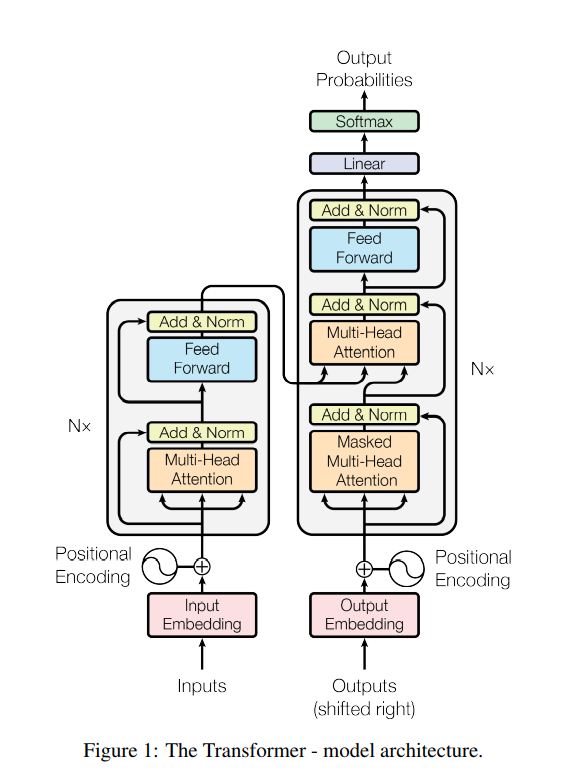

In [ ]:
Image(filename='/content/drive/MyDrive/lms/transformer_translation/Transformer.png') 

##Transformer

In [ ]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [ ]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

In [ ]:
def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [ ]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]

    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

##Learning Rate Schedule 

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

##Loss Function

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

##Train Step

In [ ]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

##Evaluation

In [ ]:
def preprocess_question(question):

    question = question.lower().strip()
    question = re.sub(r"([?.!])", r" \1 ", question)
    question = re.sub(r'[" "]+', " ", question)
    question = re.sub(r"[^0-9ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!]+", " ", question)
    question = question.strip()

    return question

In [ ]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_question(sentence)
    
    s = src_tokenizer.morphs(sentence)
    tokens = []
    for i in s:
        tokens.append(word_to_index[i])
    pieces = tokens        
        
    # pieces = src_tokenizer.encode_as_pieces(sentence)
    # tokens = src_tokenizer.encode_as_ids(sentence)
        
    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([1], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if predicted_id == 3:
            # result = tgt_tokenizer.decode_ids(ids)
            result = []
            for i in ids:
                result.append(index_to_word[i])
            
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    # result = tgt_tokenizer.decode_ids(ids)
    result = ''
    for i in ids:
        result += index_to_word[i]
    
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [ ]:
def answer_generate(sentence, model, src_tokenizer, tgt_tokenizer):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    return result

In [ ]:
def answer_print(sentence, model, src_tokenizer, tgt_tokenizer):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print(f'Input: {sentence}')
    print(f'Predicted Answer: {" ".join(result)}')

#BLEU Score

In [ ]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)

In [ ]:
def eval_bleu(src_corpus, tgt_corpus, model, verbose=True):
    total_score = 0.0
    sample_size = len(tgt_corpus)

    for idx in tqdm(range(sample_size)):
        src_tokens = src_corpus[idx]
        tgt_tokens = tgt_corpus[idx]

    # src_sentence = tokenizer.decode_ids((src_tokens.tolist()))
    # tgt_sentence = tokenizer.decode_ids((tgt_tokens.tolist()))

        src_sentence = []
        tgt_sentence = []
        
        for w in src_tokens:
            if w != 0:
                ow = index_to_word[w]
                src_sentence.append(ow)

        src_sentence = ' '.join(src_sentence)
        
        for w in tgt_tokens:
            if w != 0 and w != 1 and w != 3:
                ow = index_to_word[w]
                tgt_sentence.append(ow)
   
        tgt_sentence = ' '.join(tgt_sentence)
        
        reference = preprocess_question(tgt_sentence).split()
        candidate = answer_generate(src_sentence, model, tokenizer, tokenizer)
        
        score = sentence_bleu([reference], candidate,
                              smoothing_function=SmoothingFunction().method1)
        total_score += score

        if verbose:
            print("Source Sentence: ", src_sentence)
            print("Model Prediction: ", " ".join(candidate))
            print("Real Answer: ", " ".join(reference))
            print("Score: %lf\n" % score)

    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

#Hyperparameter

In [ ]:
reorderlist = ['Encoder & Decoder Layer', 'Model Dimension', 'Feedforwad Hidden Layer', 'Feedforward Network Dimension',
               'Normalization Layer', 'Tokenizer', 'SRC Vocab Size', 'TGT Vocab Size', 'POS Length', 'Text Max Length',
               'Dropout Rate', 'Shared FC', 'Shared EMB', 'Learning Rate', 'Optimizer', 'Activation Function',
               'Loss Function', 'Epoch', 'Batch Size']

first_hyperparameter = pd.DataFrame({'First Model':{'Encoder & Decoder Layer':2, 'Model Dimension':512,
                                     'Feedforwad Hidden Layer':8, 'Feedforward Network Dimension':2048,
                                     'Normalization Layer':'Pre-LN', 'Tokenizer':'MeCab',
                                     'SRC Vocab Size':20000, 'TGT Vocab Size':20000,
                                     'POS Length':200, 'Text Max Length':40, 'Dropout Rate':0.3,
                                     'Shared FC': 'True', 'Shared EMB': 'True',
                                     'Learning Rate':'Scheduler', 'Optimizer':'Adam', 'Activation Function':'Relu',
                                     'Loss Function':'Sparse Categorical Crossentropy', 'Epoch':5, 'Batch Size':64}})

first_hyperparameter = first_hyperparameter.iloc[pd.Categorical(first_hyperparameter.index,reorderlist).argsort()]

first_hyperparameter.loc[:,'Second Model'] = [2, 1024, 8, 4096, 'Pre-LN', 'MeCab', 20000, 20000,
                                              200, 40, 0.3, 'True', 'True', 'Scheduler', 'Adam', 'Relu',
                                              'Sparse Categorical Crossentropy', 5, 256]


pd.set_option('display.max_columns', None)
first_hyperparameter

,First Model,Second Model
Encoder & Decoder Layer,2,2
Model Dimension,512,1024
Feedforwad Hidden Layer,8,8
Feedforward Network Dimension,2048,4096
Normalization Layer,Pre-LN,Pre-LN
Tokenizer,MeCab,MeCab
SRC Vocab Size,20000,20000
TGT Vocab Size,20000,20000
POS Length,200,200
Text Max Length,40,40


#First Model

In [ ]:
vocab_size = 20000
d_model = 512

first_transformer = Transformer(n_layers=2,
                          d_model=512,
                          n_heads=8,
                          d_ff=2048,
                          src_vocab_size=vocab_size,
                          tgt_vocab_size=vocab_size,
                          pos_len=200,
                          dropout=0.3,
                          shared_fc=True,
                          shared_emb=True)

In [ ]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [ ]:
first_model_loss_df = pd.DataFrame({'Epoch':[0], 'Loss':[0]})

batch_size = 64
epochs = 5
train_count = 0
tokenizer = Mecab()
 
sentence_list = ["지루하다, 놀러가고 싶어.", "오늘 일찍 일어났더니 피곤하다.",
                 "간만에 여자친구랑 데이트 하기로 했어.", "집에 있는다는 소리야."]

for epoch in range(epochs):
      total_loss = 0

      idx_list = list(range(0, enc_train.shape[0], batch_size))
      random.shuffle(idx_list)

      for (batch, idx) in enumerate(idx_list):
          batch_loss, enc_attns, dec_attns, dec_enc_attns = \
          train_step(enc_train[idx:idx+batch_size],
                     dec_train[idx:idx+batch_size],
                     first_transformer,
                     optimizer)

          total_loss += batch_loss

          train_count += 1

          if train_count % len(idx_list) == 0:
              first_model_loss_df.loc[epoch] = [epoch + 1, round(total_loss.numpy() / (batch + 1), 4)]
              first_model_loss_df = first_model_loss_df.astype({'Epoch':'int'})
              print('Epoch {}'.format(epoch + 1))
              print('Loss {:.4f}'.format(total_loss.numpy() / (batch + 1)))
              print()

              for sentence in sentence_list:
                  answer_print(sentence, first_transformer, tokenizer, tokenizer)
                  print()
              print()

Epoch 1
Loss 5.3369

Input: 지루하다, 놀러가고 싶어.
Predicted Answer: 나 만 안 되 네

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted Answer: 오늘 도 끝 났 네

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted Answer: 여자 친구 가 좋 아 하 는 사람 이 있 는 게 좋 아 .

Input: 집에 있는다는 소리야.
Predicted Answer: 남자 친구 가 좋 아 하 는 거 같 아


Epoch 2
Loss 2.4290

Input: 지루하다, 놀러가고 싶어.
Predicted Answer: 언제 다시 붙잡 고 왔 어

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted Answer: 오늘 따라 좋 아 하 는 거 같 은 거 같 은데

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted Answer: 썸 은 데 만들 되 는 것 같 아

Input: 집에 있는다는 소리야.
Predicted Answer: 5 년 째 데이트 만났 고 있 어


Epoch 3
Loss 1.2319

Input: 지루하다, 놀러가고 싶어.
Predicted Answer: 다시 붙잡 고 있 을까

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted Answer: 오늘 은 웃 는 게 좋 아

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted Answer: 여자 친구 가 담배 를 보내 다 나 ?

Input: 집에 있는다는 소리야.
Predicted Answer: 데이트 하 는 데 데이트 하 고 싶 어 .


Epoch 4
Loss 1.0411

Input: 지루하다, 놀러가고 싶어.
Predicted Answer: 게임 에서 첫 사랑 하 고 싶 어

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted Answer: 아침 챙겨 하 게 좋 겠 어

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted Answer: 

,Epoch,Loss
0,1,5.3369
1,2,2.4290
2,3,1.2319
3,4,1.0411
4,5,0.9984


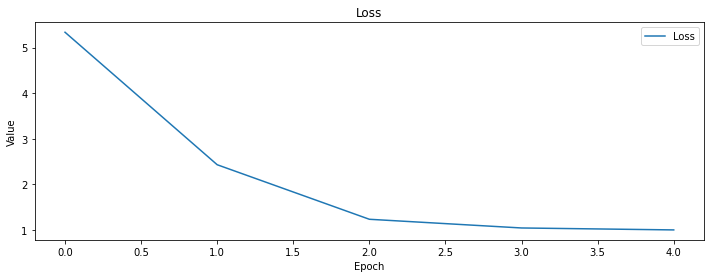

In [ ]:
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

display(first_model_loss_df)
print("\n")

plt.figure(figsize=[12, 4])
plt.plot(first_model_loss_df['Loss'] , label="Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

In [ ]:
first_model_loss_df.to_csv("/content/drive/MyDrive/lms/transformer_chatbot/first_model_loss.csv", index = False)

챗봇의 경우, 올바른 대답을 하는지가 중요한 평가 지표이다.
<br/>올바른 답변을 하는지 눈으로 확인할 수 있겠지만, 많은 데이터의 경우는 모든 결과를 확인할 수 없다.
<br/>주어진 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 calculate_bleu() 함수도 적용한다.

In [ ]:
for sentence in sentence_list:
  answer_print(sentence, first_transformer, tokenizer, tokenizer)
  print()

Input: 지루하다, 놀러가고 싶어.
Predicted Answer: 헤어져야 하 는 게 맞 는 데 돈 이 걸까 ?

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted Answer: 조급 은 나 여 고 싶 어

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted Answer: 친구 들 은 이렇게 마음 작용 이 중요 해 주 는 게 좋 아 하 는 방법 기분 이 있 는 걸까 ?

Input: 집에 있는다는 소리야.
Predicted Answer: 헤어진 여자 애 한테 어떻게 해야 겠지 ?



In [ ]:
eval_bleu(enc_val[:3], dec_val[:3], first_transformer, True)

  0%|          | 0/3 [00:00<?, ?it/s]

Source Sentence:  잠깐 주무세요 .
Model Prediction:  추우 니까 나가 기 싫 어
Real Answer:  추우 니까 나가 기 싫 어
Score: 1.000000

Source Sentence:  그럴수록 당신 이 힘들 거 예요 .
Model Prediction:  잊 을 수 없 다는 거 이제 알 겠 네
Real Answer:  잊 를 수 없 다는 거 이제 알 겠 네
Score: 0.782542

Source Sentence:  연예인 걱정 이 제일 일부러 어 요 .
Model Prediction:  연애 위기 인 거 같 아
Real Answer:  연애 위기 인 거 같 아
Score: 1.000000

Num of Sample: 3
Total Score: 0.9275140966788813


In [ ]:
eval_bleu(enc_val, dec_val, first_transformer, False)

  0%|          | 0/512 [00:00<?, ?it/s]

Num of Sample: 512
Total Score: 0.3553519578841624


#Second Model

In [ ]:
vocab_size = 20000
d_model = 1024

second_transformer = Transformer(n_layers=2,
                          d_model=1024,
                          n_heads=8,
                          d_ff=4096,
                          src_vocab_size=vocab_size,
                          tgt_vocab_size=vocab_size,
                          pos_len=200,
                          dropout=0.3,
                          shared_fc=True,
                          shared_emb=True)

In [ ]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [ ]:
second_model_loss_df = pd.DataFrame({'Epoch':[0], 'Loss':[0]})

batch_size = 256
epochs = 5
train_count = 0
tokenizer = Mecab()
 
sentence_list = ["지루하다, 놀러가고 싶어.", "오늘 일찍 일어났더니 피곤하다.",
                 "간만에 여자친구랑 데이트 하기로 했어.", "집에 있는다는 소리야."]

for epoch in range(epochs):
      total_loss = 0

      idx_list = list(range(0, enc_train.shape[0], batch_size))
      random.shuffle(idx_list)

      for (batch, idx) in enumerate(idx_list):
          batch_loss, enc_attns, dec_attns, dec_enc_attns = \
          train_step(enc_train[idx:idx+batch_size],
                     dec_train[idx:idx+batch_size],
                     second_transformer,
                     optimizer)

          total_loss += batch_loss

          train_count += 1

          if train_count % len(idx_list) == 0:
              second_model_loss_df.loc[epoch] = [epoch + 1, round(total_loss.numpy() / (batch + 1), 4)]
              second_model_loss_df = second_model_loss_df.astype({'Epoch':'int'})
              print('Epoch {}'.format(epoch + 1))
              print('Loss {:.4f}'.format(total_loss.numpy() / (batch + 1)))
              print()

              for sentence in sentence_list:
                  answer_print(sentence, second_transformer, tokenizer, tokenizer)
                  print()
              print()

Epoch 1
Loss 6.8999

Input: 지루하다, 놀러가고 싶어.
Predicted Answer: 이별 하 는 사람 이

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted Answer: 좋 아 하 는 사람 이 네

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted Answer: 남자 친구 가 나

Input: 집에 있는다는 소리야.
Predicted Answer: 내 가 가 좋 아


Epoch 2
Loss 4.5029

Input: 지루하다, 놀러가고 싶어.
Predicted Answer: 이 별 이 네

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted Answer: 오늘 도 좋 아 하 는 사람 이 뭐 가 좋 아 하 는 것 같 아

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted Answer: 나 를 좋아하 는 사람 이 너무 힘들 어

Input: 집에 있는다는 소리야.
Predicted Answer: 내 가 너무 많 아


Epoch 3
Loss 2.8705

Input: 지루하다, 놀러가고 싶어.
Predicted Answer: 헤어진지 1 년 째

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted Answer: 공휴일 이 너무 많 아

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted Answer: 나 를 좋아하 는 사람 이랑 내 가 나 의 나 만 싫 어 .

Input: 집에 있는다는 소리야.
Predicted Answer: 미끄러질 먹 었


Epoch 4
Loss 1.2792

Input: 지루하다, 놀러가고 싶어.
Predicted Answer: 연애 안 됐 어

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted Answer: 기다리 고 이 것 같 은 것 같 아

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted Answer: 내 가 연락 이 나 는 것 같 아

Input: 집에 있는다는 소리야.
Pred

,Epoch,Loss
0,1,6.8999
1,2,4.5029
2,3,2.8705
3,4,1.2792
4,5,0.6900


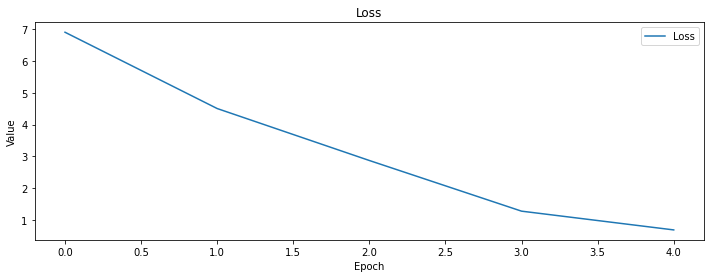

In [ ]:
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

display(second_model_loss_df)
print("\n")

plt.figure(figsize=[12, 4])
plt.plot(second_model_loss_df['Loss'] , label="Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

In [ ]:
second_model_loss_df.to_csv("/content/drive/MyDrive/lms/transformer_chatbot/second_model_loss.csv", index = False)

In [ ]:
for sentence in sentence_list:
  answer_print(sentence, second_transformer, tokenizer, tokenizer)
  print()

Input: 지루하다, 놀러가고 싶어.
Predicted Answer: 연애 를 하 네

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted Answer: 기다리 고 이 것 같 아

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted Answer: 짝 남 이랑 생각 했 던 내 친구 는 나 의 이야기 .

Input: 집에 있는다는 소리야.
Predicted Answer: 오늘 따라 ?



In [ ]:
eval_bleu(enc_val[:3], dec_val[:3], second_transformer, True)

  0%|          | 0/3 [00:00<?, ?it/s]

Source Sentence:  많이 힘들 었 겠 어요 .
Model Prediction:  해선 안 될 사랑 .
Real Answer:  해선 안 될 사랑 .
Score: 1.000000

Source Sentence:  그분 생각 으로 가득 찼 나 봐요 .
Model Prediction:  벌써 한 달 은 었 다 되 었 다
Real Answer:  벌써 한 달 이 되 었 이
Score: 0.149237

Source Sentence:  침대 와 한 몸 이 되 어 푹 쉬 세요 .
Model Prediction:  친구 한테 몇 년 만 에 연락 해도 되 나
Real Answer:  친구 한테 몇 년 만 이 에 연락 해도 되 나
Score: 0.710867

Num of Sample: 3
Total Score: 0.6200346945918417


In [ ]:
eval_bleu(enc_val, dec_val, second_transformer, False)

  0%|          | 0/512 [00:00<?, ?it/s]

Num of Sample: 512
Total Score: 0.5123873628903671


#최종 모델

,First Model
Encoder & Decoder Layer,2
Model Dimension,1024
Feedforwad Hidden Layer,8
Feedforward Network Dimension,4096
Normalization Layer,Pre-LN
Tokenizer,MeCab
SRC Vocab Size,20000
TGT Vocab Size,20000
POS Length,200
Text Max Length,40


,Epoch,Loss
0,1,6.8999
1,2,4.5029
2,3,2.8705
3,4,1.2792
4,5,0.6900


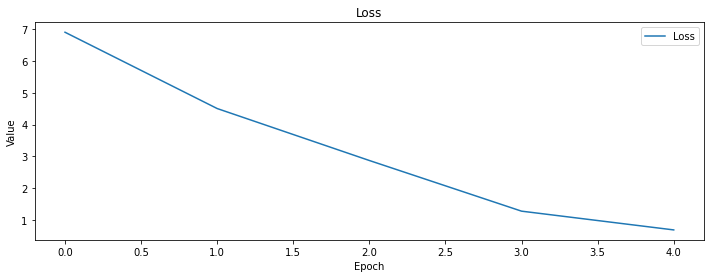



Input: 지루하다, 놀러가고 싶어.
Predicted Answer: 연애 를 하 네

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted Answer: 기다리 고 이 것 같 아

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted Answer: 짝 남 이랑 생각 했 던 내 친구 는 나 의 이야기 .

Input: 집에 있는다는 소리야.
Predicted Answer: 오늘 따라 ?





  0%|          | 0/512 [00:00<?, ?it/s]

Num of Sample: 512
Total Score: 0.5123873628903671


In [ ]:
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

reorderlist = ['Encoder & Decoder Layer', 'Model Dimension', 'Feedforwad Hidden Layer', 'Feedforward Network Dimension',
               'Normalization Layer', 'Tokenizer', 'SRC Vocab Size', 'TGT Vocab Size', 'POS Length', 'Text Max Length',
               'Dropout Rate', 'Shared FC', 'Shared EMB', 'Learning Rate', 'Optimizer', 'Activation Function',
               'Loss Function', 'Epoch', 'Batch Size']

final_hyperparameter = pd.DataFrame({'First Model':{'Encoder & Decoder Layer':2, 'Model Dimension':1024,
                                     'Feedforwad Hidden Layer':8, 'Feedforward Network Dimension':4096,
                                     'Normalization Layer':'Pre-LN', 'Tokenizer':'MeCab',
                                     'SRC Vocab Size':20000, 'TGT Vocab Size':20000,
                                     'POS Length':200, 'Text Max Length':40, 'Dropout Rate':0.3,
                                     'Shared FC': 'True', 'Shared EMB': 'True',
                                     'Learning Rate':'Scheduler', 'Optimizer':'Adam', 'Activation Function':'Relu',
                                     'Loss Function':'Sparse Categorical Crossentropy', 'Epoch':5, 'Batch Size':256}})

final_hyperparameter = final_hyperparameter.iloc[pd.Categorical(final_hyperparameter.index,reorderlist).argsort()]

final_model_loss_df = pd.read_csv("/content/drive/MyDrive/lms/transformer_chatbot/second_model_loss.csv")
final_model_loss_df.to_csv("/content/drive/MyDrive/lms/transformer_chatbot/final_model_loss.csv", index = False)

with pd.option_context('display.max_rows',None):
  display(final_hyperparameter)
print("\n")
display(final_model_loss_df)
print("\n")

plt.figure(figsize=[12, 4])
plt.plot(final_model_loss_df['Loss'] , label="Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()
print("\n")

for sentence in sentence_list:
  answer_print(sentence, second_transformer, tokenizer, tokenizer)
  print()
print("\n")
eval_bleu(enc_val, dec_val, second_transformer, False)

#결론

**하이퍼파라미터**

임베딩 차원의 깊이에 따라 모델의 성능이 어떻게 달라지는지 알고 싶다.
<br/>워드 임베딩 하이퍼파라미터에 대한 공부의 필요성을 느낀다.

**워드 임베딩**

Word2Vec, Glove, FastText의 방식에 따라 Word Vector를 시각화했을 때
<br/>동일한 단어를 입력했음에도 서로 다른 모습의 PCA Scatter Plot을 출력한다.
<br/>Word2Vec, Glove, FastText 텐서 연산 방법의 차이에 대한 공부의 필요성을 느낀다.

#참고문헌

**LMS**
<br/>[dev-sngwn](https://github.com/dev-sngwn)

<br/>**단행본**
<br/>유원준 외 1명, 『딥러닝을 이용한 자연어 처리 입문』, Wikidocs, 2022
<br/>[사전 훈련된 워드 임베딩(Pre-trained Word Embedding)](https://wikidocs.net/33793)

<br/>**공식 사이트**
<br/>Stanford University CS224n
<br/>[Gensim word vector visualization of various word vectors](https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html)

<br/>**깃허브**
<br/>songys
<br/>[Chatbot data for Korean v1.0](https://github.com/songys/Chatbot_data)
<br/><br/>Kyubyong
<br/>[Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)
<br/>[Pre-trained Korean Word2Vec model](https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view?resourcekey=0-Dq9yyzwZxAqT3J02qvnFwg)
<br/><br/>ratsgo
<br/>[단어 임베딩 데이터 다운로드](https://ratsgo.github.io/embedding/downloaddata.html)
<br/><br/>yeoooo
<br/>[(GD6)BLEU_Score_yeoooo_2021-05-07.ipynb](https://github.com/yeoooo/Aiffel/blob/master/(GD6)BLEU_Score_yeoooo_2021-05-07.ipynb)
<br/><br/>suheeeee
<br/>[GD_NLP_6_transformer_chatbot.ipynb](https://github.com/suheeeee/my_deeplearning_project/blob/main/going_deeper/GD_NLP_6_transformer_chatbot.ipynb)

<br/>**웹사이트**
<br/>[다음 카페 사랑보다 아름다운 실연](http://cafe116.daum.net/_c21_/home?grpid=1bld)
<br/>[형용사모음, 다양한 형용사모음 준비했습니다](https://m.post.naver.com/viewer/postView.naver?volumeNo=32582245&memberNo=28172842)
<br/>[Load Pretrained glove vectors in python](https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python)
<br/>[python how to write list of lists to file](https://stackoverflow.com/questions/30711899/python-how-to-write-list-of-lists-to-file)
<br/>[python  Gensim을 사용하여 Python에서 Word 임베딩을 개발하는 방법](https://ngio.co.kr/9518)
<br/>[파이썬 print 문 출력결과 가지고 놀기](https://light-tree.tistory.com/109)
<br/>[Reading a list of lists from a file as list of lists in python](https://stackoverflow.com/questions/10294310/reading-a-list-of-lists-from-a-file-as-list-of-lists-in-python)
<br/>[python 에러: 'list' object is not callable](https://janeljs.github.io/python/not-callable/)
<br/>[Python Pandas의 기존 DataFrame에 새 열 추가](https://www.delftstack.com/ko/howto/python-pandas/how-to-add-new-column-to-existing-dataframe-in-python-pandas/)
<br/>[Python 파이썬 리스트 문자열 합치기 Join 함수](https://needneo.tistory.com/92)